In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.constants import N_A
import pints
from scipy.integrate import solve_ivp
import pints.plot
import pathlib
sns.set_context('talk')
from lmfit import Model

In [324]:
Target_cell_number = 5e4
well_size = 50e-6
sigma = well_size*N_A/Target_cell_number
tumour_cell_radius = 8e-6
parameter_names=[r'$k_{on}$', r'$K_D$', r'$k_2$', 'C', 'noise1', 'noise2']
t_end = 60*60*1
t = np.geomspace(1e-10, t_end, 50)
rtot = 5.3e4
tspan = [1e-10, t_end]

kons = [2.5e5, 1.4e5, 2e5, 1.1e5]
KDs = [0.6e-9, 24e-9, 7e-9,  148e-9]

In [325]:
print(sigma)

602214076000000.0


In [326]:
def model_eqns(t, z, kon, KD, k2, rtot, Ainit):
    Atot = Ainit*sigma
    k1 = kon/sigma
    A0 = Atot - z[0] - z[1]
    r = rtot - z[0] - 2*z[1]

    dA1 = 2*k1*r*A0 - (KD*kon)*z[0] - k2*r*z[0] + 2*(KD*kon)*z[1]
    dA2 = k2*z[0]*r - 2*(KD*kon)*z[1]

    return [dA1, dA2]


def solve_model_individual(kon, KD, k2, rtot, A0s):
    solution = np.zeros_like(A0s)
    z0 = [0, 0]
    for i, Ainit in enumerate(A0s):
        z = solve_ivp(model_eqns, tspan, z0, method='Radau', t_eval=t, args=(kon, KD, k2, rtot, Ainit))
        A1 = z.y[0]
        A2 = z.y[1]
        bound_ab = A1[-1] + A2[-1]
        solution[i] = bound_ab
    
    return solution

def simulate_model(A0s, parameters):

    kon1 = parameters[0]
    kon1 = 10**kon1
    KD1 = parameters[1]
    KD1 = 10**KD1
    kon2 = parameters[2]
    kon2 = 10**kon2
    KD2 = parameters[3]
    KD2 = 10**KD2
    kon3 = parameters[4]
    kon3 = 10**kon3
    KD3 = parameters[5]
    KD3 = 10**KD3
    kon4 = parameters[6]
    kon4 = 10**kon4
    KD4 = parameters[7]
    KD4 = 10**KD4
    k2 = parameters[8]
    k2 = 10**k2
    C = parameters[9]
    C=10**C
    b = parameters[10]
    b = 10**b
    solution = np.zeros((len(A0s)))
    kon_params = [kon1, kon2, kon3, kon4]
    KD_params = [KD1, KD2, KD3, KD4]

    for i in range(len(kon_params)):
        solution[:, i] = (solve_model_individual(kon_params[i], KD_params[i], k2, rtot, A0s))

    return np.log10((C*solution + b)/rtot)

def simulate_model1(A0s, parameters):

    k2 = parameters[0]
    k2 = 10**k2
    C = parameters[1]
    C=10**C
    b = parameters[2]
    b = 10**b
    solution = np.zeros((len(A0s), len(kons)))
    for i in range(len(kons)):
        solution[:, i] = (solve_model_individual(kons[i], KDs[i], k2, rtot, A0s))

    return (C*solution + b)/rtot

def simulate_model_ls(A0s, k2, C, b):
    k2 = 10**k2
    C = 10**C
    b = 10**b
    solutions = []
    for i in range(len(kons)):
        solution1 = np.zeros((len(A0s)))
        solution1[:] = (solve_model_individual(kons[i], KDs[i], k2, rtot, A0s))
        solutions.append((solution1)/rtot)
    
    solution = np.asarray(np.concatenate(([solutions[i] for i in range(len(solutions))])))
    return solution

In [327]:
data1 = []

from pathlib import Path
pathlist = Path('/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_binding_data/SK0V3').glob('**/*.csv')

for path in pathlist:
    print(path)
    df = pd.read_csv(str(path))
    conc = df['CONCENTRATION'].values
    conc = conc*1e-9
    vals = df['MFI'].values
    data1.append(vals*1e4/rtot)

data = np.log10(np.stack((data1), axis=1))
data3 = np.stack((data1), axis=1)
data2 = np.asarray(np.concatenate(([data1[i] for i in range(len(data1))])))
A0s = conc

/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_binding_data/SK0V3/WT.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_binding_data/SK0V3/VKS93A_VHP97A.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_binding_data/SK0V3/VKF94A.csv
/Users/lukeheirene/ADCC-Project/GSK_mono_biv_project/Synapse Model Parameter Fitting/Mazor_binding_data/SK0V3/VKF94A_VHP97A.csv


In [328]:
print(data)

[[-1.95661303 -3.21188554 -2.43373429 -2.91085554]
 [-1.65558304 -2.73476428 -1.8501577  -2.73476428]
 [-1.34856268 -2.25764303 -1.56843286 -2.73476428]
 [-1.03579428 -1.91085554 -1.25284414 -1.93313193]
 [-0.86163752 -1.52168946 -0.9043895  -1.52168946]
 [-0.74799255 -1.17049285 -0.79524503 -1.17846178]
 [-0.70809485 -0.91303246 -0.73331904 -0.95420696]
 [-0.6894413  -0.77572289 -0.70268301 -0.87144142]]


In [329]:
ls_model = Model(simulate_model_ls)
ls_model.set_param_hint('k2', min = 12, max = -1)
ls_model.set_param_hint('C', min = -2, max = 3)
ls_model.set_param_hint('b', min = -6, max = 10)


parameters = ls_model.make_params(k2=-8, C=1, b=2)

result = ls_model.fit(data2, parameters, A0s=A0s)
print(result.fit_report())

[[Model]]
    Model(simulate_model_ls)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 32
    # variables        = 3
    chi-square         = 3.02488854
    reduced chi-square = 0.10430650
    Akaike info crit   = -69.4835730
    Bayesian info crit = -65.0863653
    R-squared          = -17.6559822
##  Warning: uncertainties could not be estimated:
    C:   at initial value
    b:   at initial value
[[Variables]]
    k2: -0.97156816 (init = 12)
    C:   1.00000000 (init = 1)
    b:   2.00000000 (init = 2)


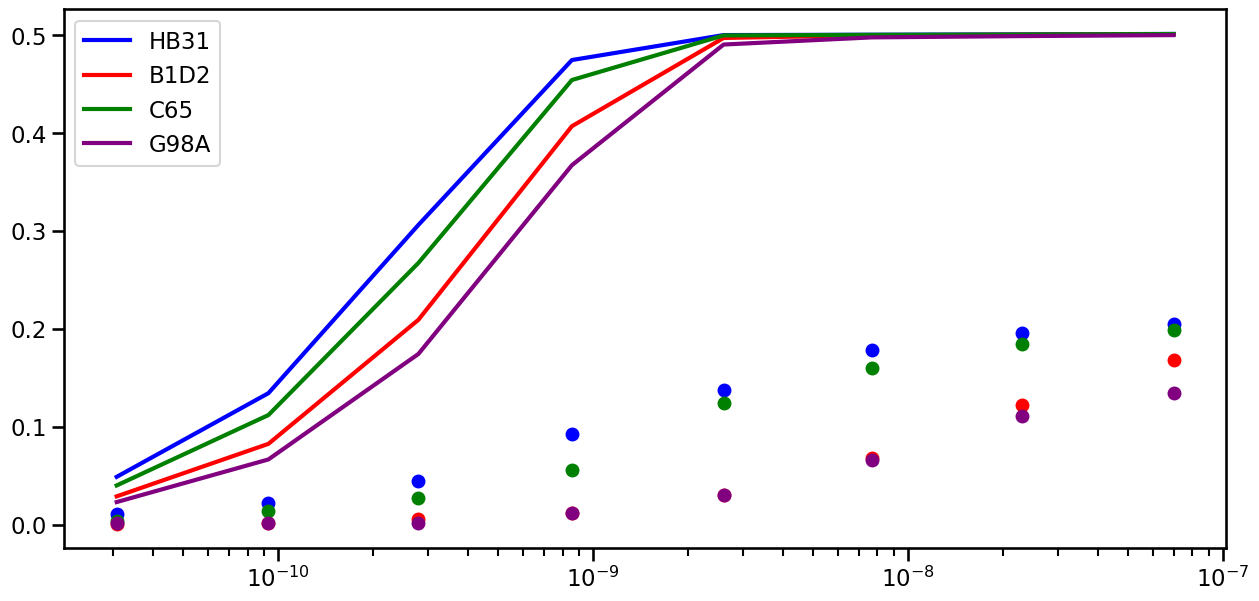

In [330]:
plt.figure(figsize=(15, 7))
param_results = result.best_values

colors = ['blue', 'red', 'green', 'purple', 'orange']
labels = ['HB31', 'B1D2', 'C65', 'G98A', 'ML3-9']
vals = simulate_model_ls(A0s, param_results['k2'], param_results['C'], param_results['b'])
for i in range(len(kons)):
    plt.plot(A0s, data3[:, i], 'o', c=colors[i])
    plt.plot(conc, vals[i*8: 8*(i+1)], label=labels[i], lw=3, c=colors[i])
plt.legend()
plt.xscale('log')
plt.show()

In [331]:
class model(pints.ForwardModel):

    def n_outputs(self):
         return 4
    
    def n_parameters(self):
        return 3
    
    def simulate(self, parameters, A0s):
        return np.log10(simulate_model1(A0s, parameters))

In [332]:
class LogPosteriorWrapper(pints.LogPDF):
    def __init__(self, log_pdf):
        self._log_pdf = log_pdf

    def __call__(self, parameters):
        # Create parameter container
        params = np.empty(shape=len(parameters)+3)

        # Fill container with parameters
        # (This solution is specific to the above presented problem)
        params[:3] = np.asarray(parameters[:3])
        params[4] = parameters[3]
        params[5] = parameters[3]
        params[6] = parameters[3]
        params[7] = parameters[3]

        return self._log_pdf(params)

    def n_parameters(self):
        return self._log_pdf.n_parameters() - 3

In [333]:
mod = model()
problem = pints.MultiOutputProblem(mod, conc, data)
log_likelihood = pints.GaussianLogLikelihood(problem)
parameters = [-5,  0.1, 2, 0.01, 0.01, 0.01, 0.01]
log_prior = pints.UniformLogPrior(
    [-11, -2, 0, 0.0001, 0.0001, 0.0001, 0.0001],
    [-1, 1, 4, 0.5, 0.5, 0.5, 0.5]
)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)
log_posterior_fixed_noise = LogPosteriorWrapper(log_posterior)

In [334]:
init_guesses = [param_results['k2'], param_results['C'], param_results['b']]
parameters_fixed_noise = init_guesses + [0.01]

In [335]:
xs = [
    np.array(parameters_fixed_noise) * 0.9,
    np.array(parameters_fixed_noise) * 1.01,
    np.array(parameters_fixed_noise) * 1.15
]

In [336]:
mcmc = pints.MCMCController(log_posterior, 3, xs)
mcmc.set_max_iterations(15000)
chains = mcmc.run()

ValueError: All initial positions must have the same dimension as the given LogPDF.

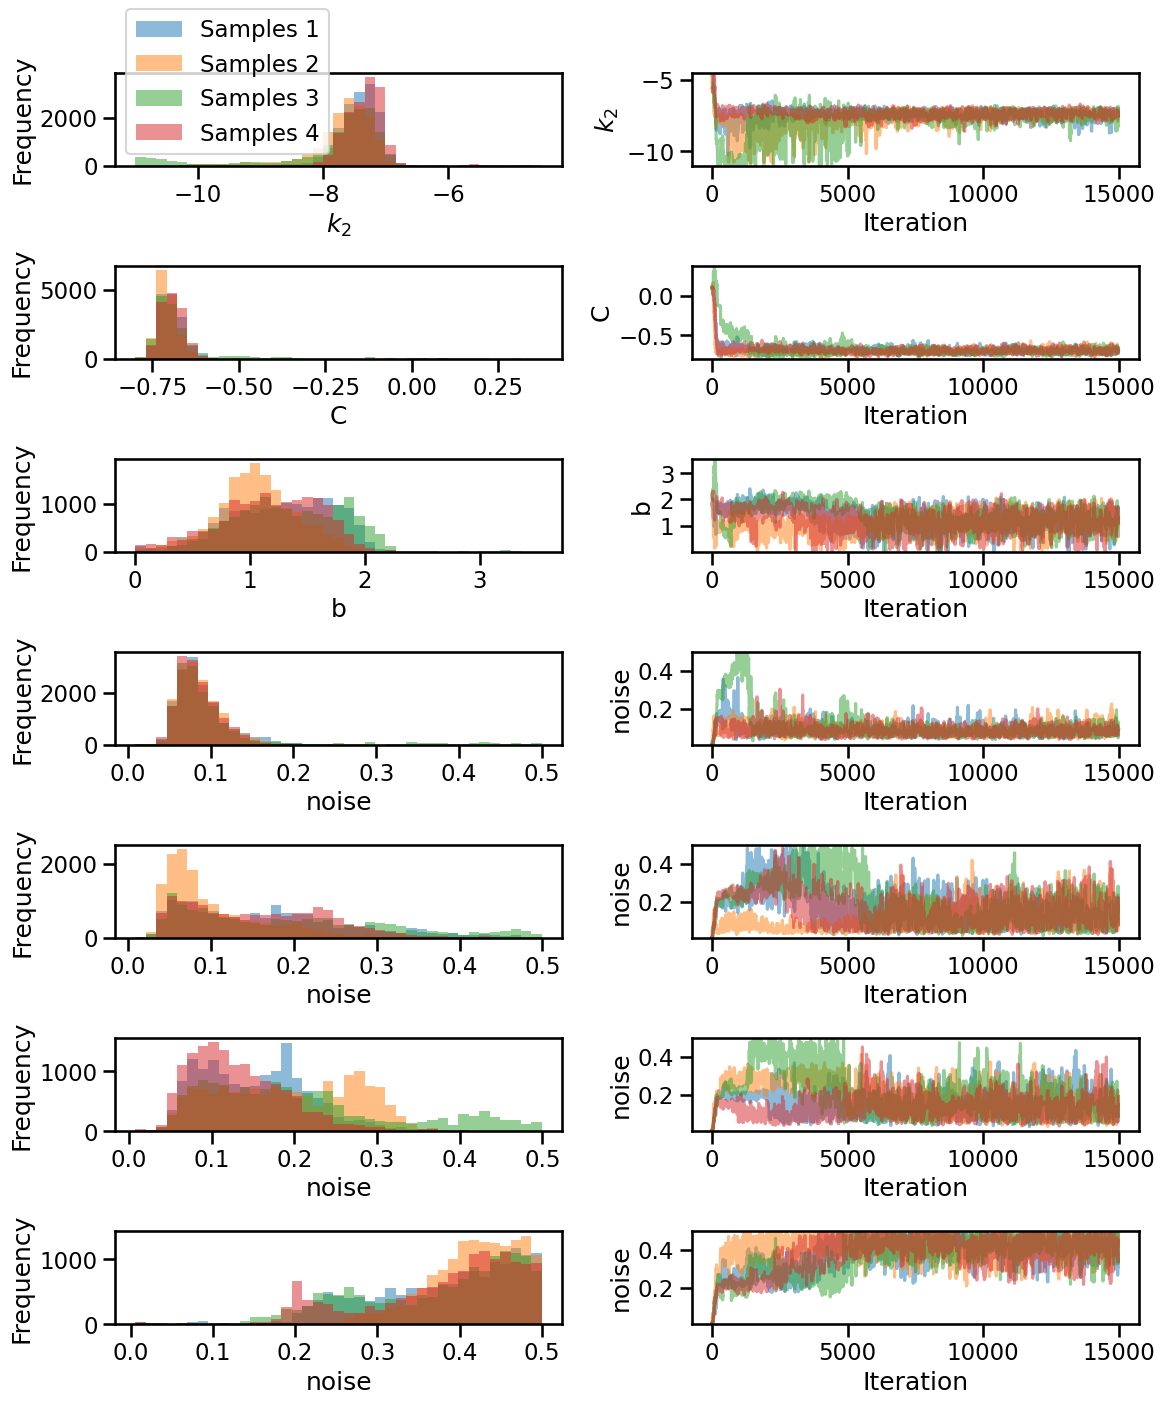

In [ ]:
import pints.plot
parameter_names=[ r'$k_2$', 'C', 'b', 'noise', 'noise', 'noise', 'noise']
pints.plot.trace(chains, parameter_names=parameter_names)
plt.show()

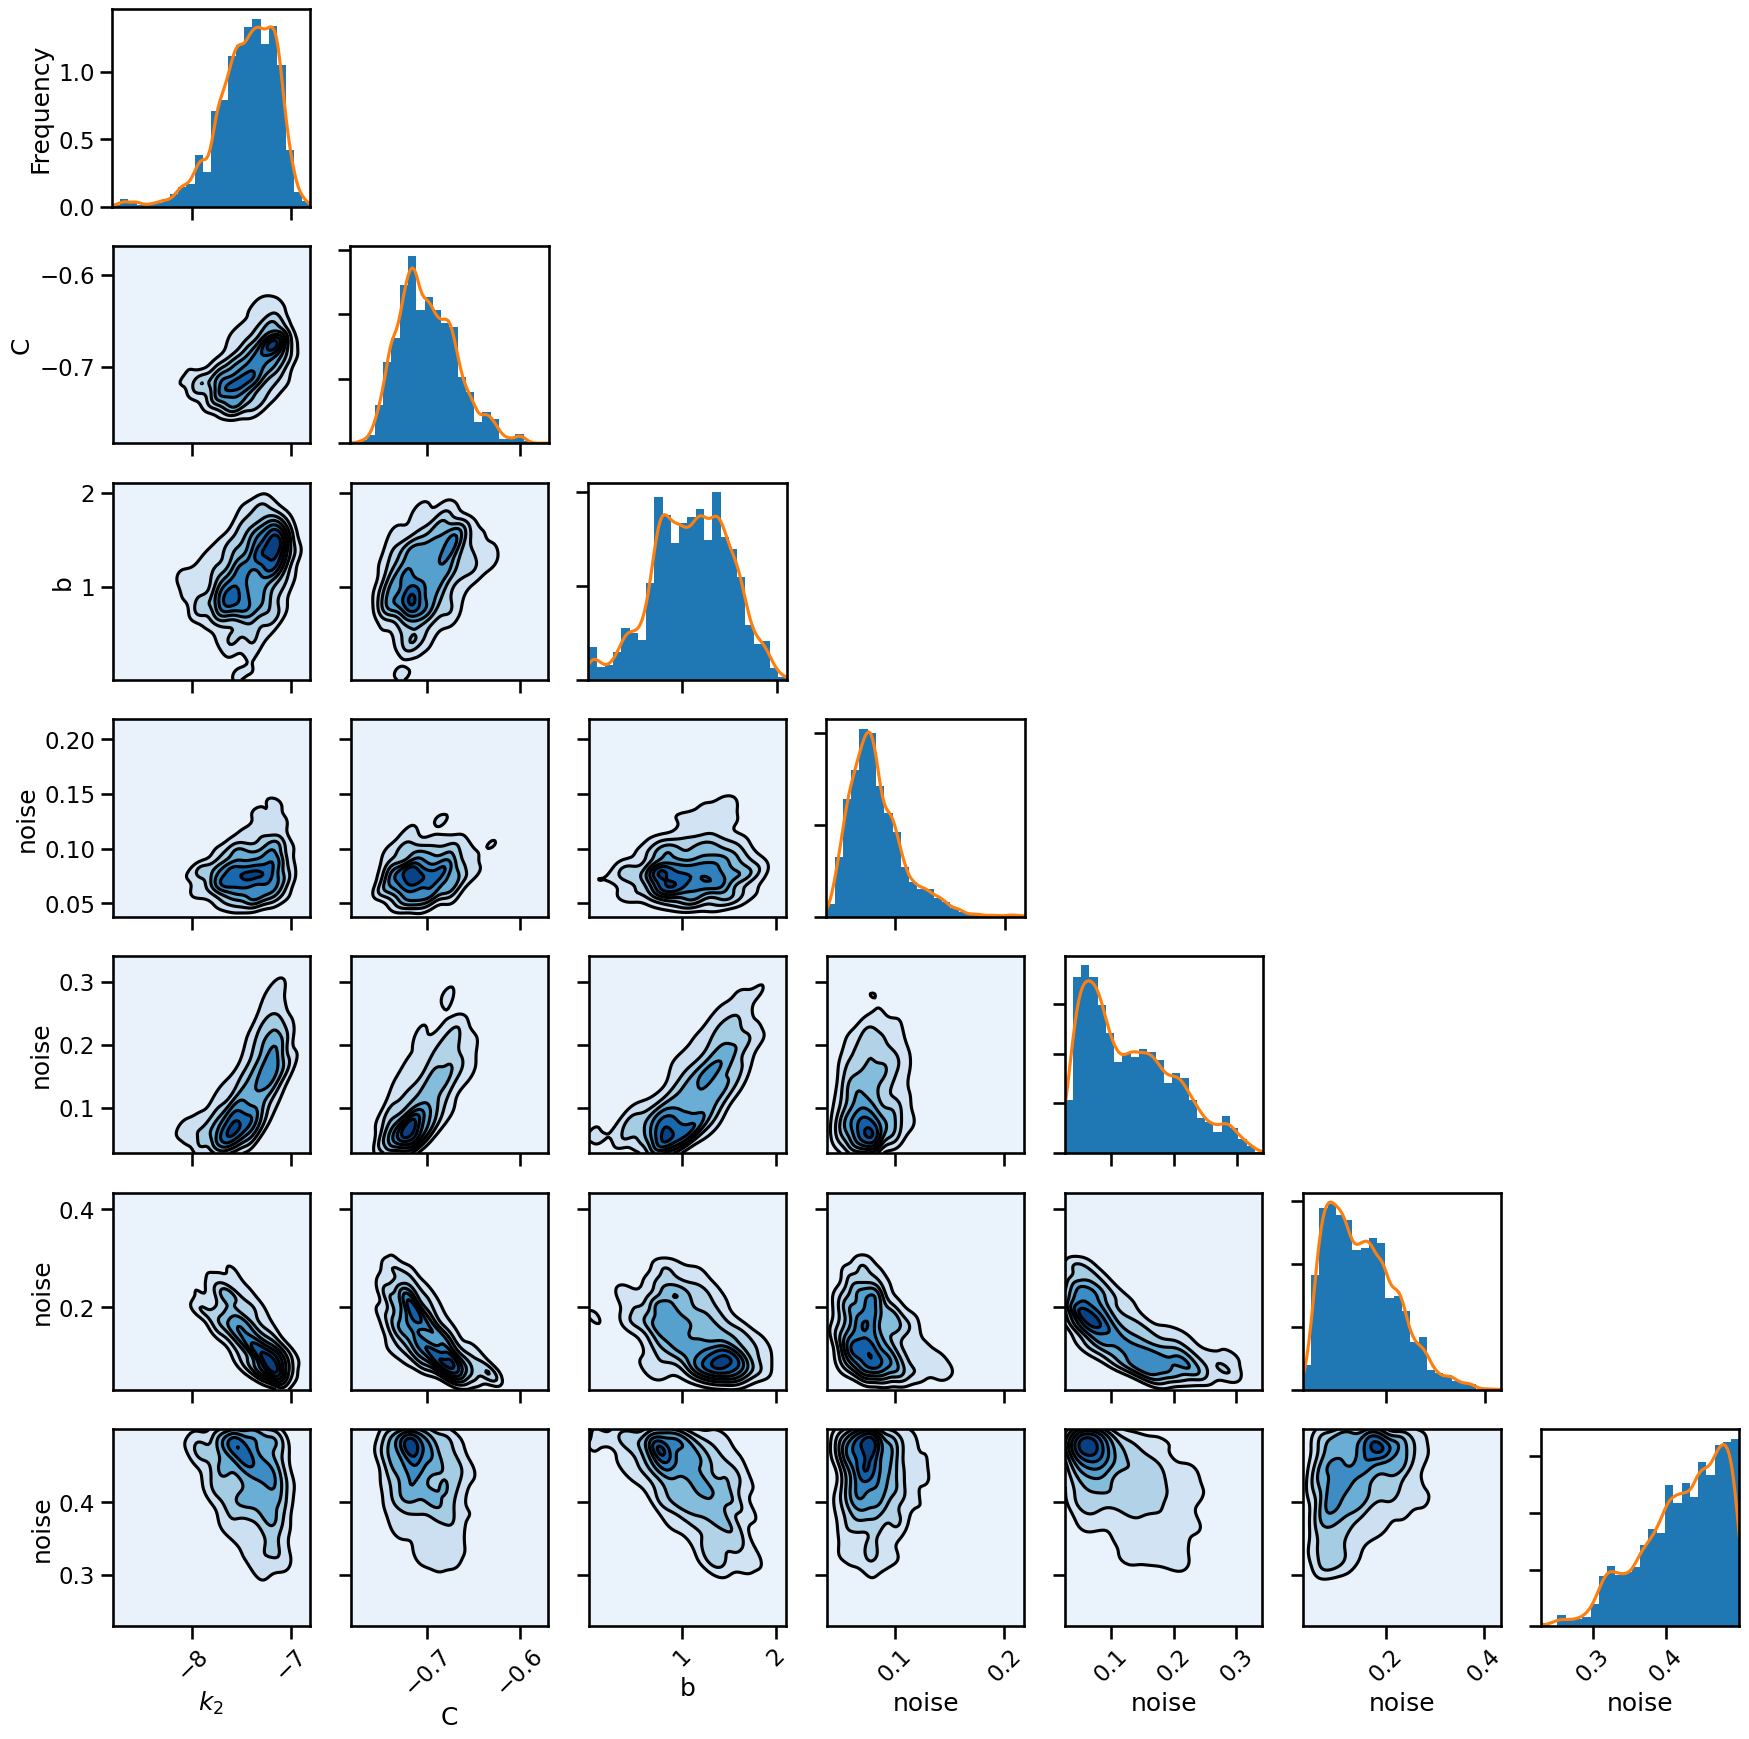

In [ ]:
chain = chains[0]
chain = chain[7500:]
chains1 = chains[:, 7500 :]
pints.plot.pairwise(chain, kde=True,  parameter_names=parameter_names)
plt.show()

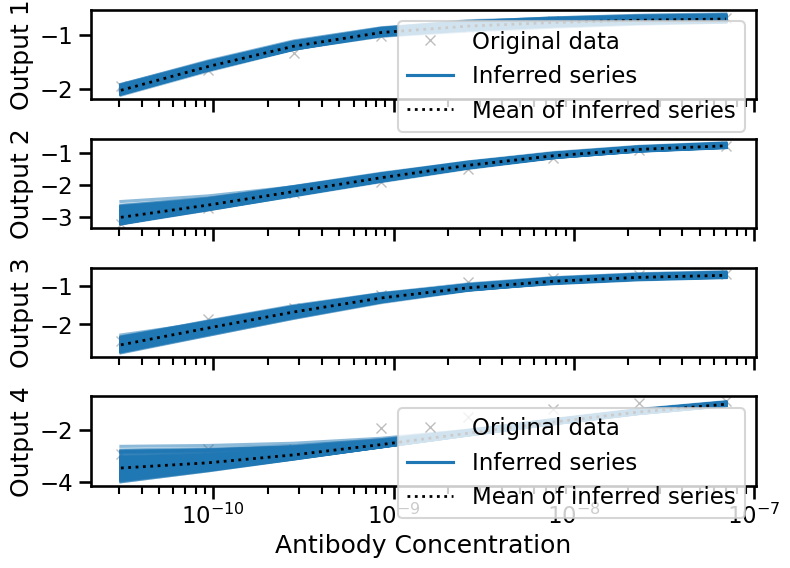

In [ ]:
fig, axes = pints.plot.series(chains1[0], problem)

plt.legend()
plt.xscale('log')
plt.xlabel(r'Antibody Concentration')
plt.show()

In [ ]:
results = pints.MCMCSummary(chains=chains1, time=mcmc.time(),parameter_names=parameter_names)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
$k_2$    -7.46   0.31    -8.16   -7.64  -7.41  -7.23  -6.99    1.03    604.48  0.19
C        -0.70   0.03    -0.75   -0.72  -0.70  -0.68  -0.63    1.01    582.00  0.18
b        1.11    0.38    0.30    0.86   1.12   1.38   1.81     1.00    722.87  0.23
noise    0.08    0.02    0.05    0.07   0.08   0.10   0.14     1.02    718.41  0.23
noise    0.13    0.07    0.04    0.07   0.12   0.18   0.29     1.02    583.93  0.18
noise    0.15    0.07    0.05    0.10   0.14   0.19   0.30     1.02    562.47  0.18
noise    0.42    0.06    0.29    0.39   0.43   0.46   0.50     1.02    651.53  0.21


In [ ]:
results_list = results._summary_list
results_dic = {}
means =[]
stds = []
l_perc = []
h_perc = []
rhats = []
parameter_names=[r'$k_2$', 'C','b']
for i, param in enumerate(parameter_names):
    holder = results_list[i]
    means.append(holder[1])
    stds.append(holder[2])
    l_perc.append(holder[3])
    h_perc.append(holder[7])
    rhats.append(holder[8])

results_dic['parameter'] = parameter_names
results_dic['mean'] = means
results_dic['std'] = stds
results_dic['2.5%'] = l_perc
results_dic['97.5%'] = h_perc
results_dic['rhat'] = rhats

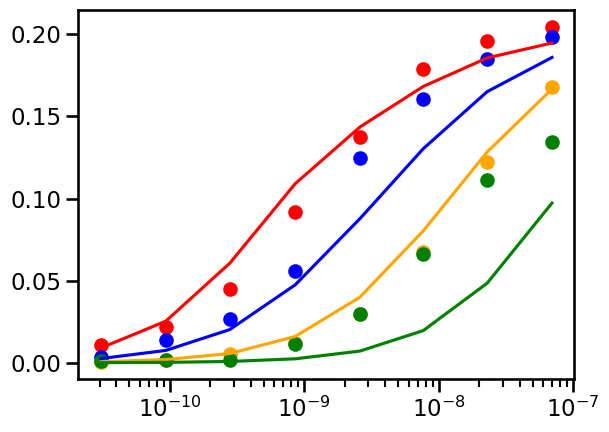

In [ ]:
#parameters = [-6.5, -0.96, 2.06]
parameters = results_dic['mean']
sim = simulate_model1(conc, parameters=parameters)
colors=['red', 'orange', 'blue', 'green']
for i in range(len(kons)):
    plt.semilogx(conc, sim[:, i], label='fit', c=colors[i])
    plt.scatter(conc, 10**data[:, i], label='data', c=colors[i])